# Introduction

Recently, I have been widely interested in the overlap between Deep Learning and Biology and decided to start learning about it. I came across an interesting challenge, where I try to build a Pneumonia Binary Classification Computer Vision model that predicts whether a chest X-ray has Pneumonia or not. I also learned a nifty approach to deal with a problem that is common in Medical Datasets, that I will show you here.

I am going to be using [fastai](https://github.com/fastai/fastai) and [PyTorch](https://github.com/pytorch/pytorch) for this tutorial. I want to extend my thanks to the author of this [dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) from Kaggle that we are going to be using today.

In [1]:
#| include: false
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.3MB/s 
     |████████████████████████████████| 1.0MB 29.0MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 194kB 36.6MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
     |████████████████████████████████| 40kB 7.1MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 2.6MB 43.2MB/s 
Mounted at /content/gdrive


In [2]:
#| include: false
!mkdir ~/.kaggle
!mkdir data

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#| include: false
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 73.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.5MB/s]


In [4]:
#| include: false
!unzip *zip -d data && rm -rf *zip

Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0447-0001.jpeg  

In [5]:
#| include: false
from fastbook import *

Let's get the packages that we will need:

In [6]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import seaborn as sns

How does our data look like?

In [7]:
path = Path('data/chest_xray')

In [8]:
#| include: false
Path.BASE_PATH = path

In [9]:
path.ls()

(#5) [Path('__MACOSX'),Path('chest_xray'),Path('val'),Path('train'),Path('test')]

It is already separated for us in the relevant folders. Awesome! Let's check inside one of the folders:

In [10]:
(path/'train').ls()

(#2) [Path('train/PNEUMONIA'),Path('train/NORMAL')]

The folders are also separated into their respective classes. How many images do we have per category?

In [11]:
train = get_image_files(path/'train')
val = get_image_files(path/'val')
test = get_image_files(path/'test')

print(f"Train: {len(train)}, Valid: {len(val)}, Test: {len(test)}")

Train: 5216, Valid: 16, Test: 624


Our validation set has only 16 images! That won't be a good measurement of how our model is performing but we will tackle that later on.

Let us check the distribution of images between the two classes:

In [12]:
normal = get_image_files(path/'train'/'NORMAL')
pneumonia = get_image_files(path/'train'/'PNEUMONIA')

print(f"Normal Images: {len(normal)}. Pneumonia Images: {len(pneumonia)}")

Normal Images: 1341. Pneumonia Images: 3875


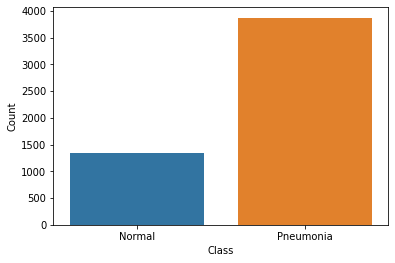

In [13]:
data = [['Normal', len(normal)], ['Pneumonia', len(pneumonia)]]
df = pd.DataFrame(data, columns=['Class', 'Count'])

sns.barplot(x=df['Class'], y=df['Count']);

Remember the problem common to Medical Datasets I was talking about? We see that our dataset is imbalanced. Our negative class (Normal) is 3 times less than our positive class. This is a problem. How do we solve it?

First, we will utilize some Data Augmentations. This is artificially growing our dataset by introducing some transforms on the images.

Second, we will use some lessons that I read from a wonderful paper: [Mateusz Buda, Atsuto Maki, and Maciej A Mazurowski. A systematic study of the class
imbalance problem in convolutional neural networks](https://arxiv.org/abs/1710.05381) that studies the problem of class imbalances and offers a way to solve it. I highly recommend reading the paper. 

However, we need to build a Baseline model that we can later improve on. 

For the Data Augmentations, we have to be careful to pick the ones that make sense for our X-Ray data. I picked Rotate and Zoom. If you think about it, transforms like flipping the image won't be useful since our body parts are in specific locations. e.g our liver is one the right, and flipping the X-Ray would take it to the opposite side.

I also utilize a nifty trick called Presizing from the fastai team. The basic idea behind this approach is this: We first resize the image to a bigger size, bigger than what we want for the final image. For instance, here, I resize the image to 460x460 first, then later on, resize it to 224x224 and at the same time, apply all the augmentaions at once. That is the most important point, applying the final resize and the transforms at the same time, preferably as a batch transform on the GPU. This helps in a higher quality image than insted, let's say, applying them one by one, which may degrade the data. To learn more about presizing, check out his [notebook](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb).

In [14]:
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    item_tfms=Resize(460),
    batch_tfms=augs
)

Let us collect the data in a dataloaders object and show one batch.

In [16]:
dls = dblock.dataloaders(path)

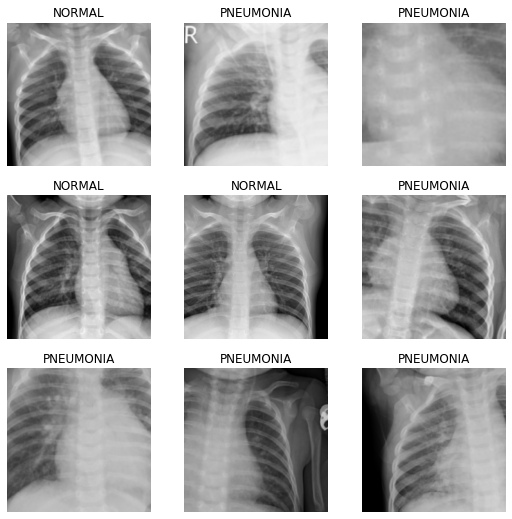

In [17]:
dls.show_batch()

We are going to utilize transfer learning on the resnet18 architecture. Our metrics to guide us are going to be error rate and accuracy.

In [18]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


We use another great tool by fastai that helps us get the optimal learning rate to use. Something around 1x10<sup>-2</sup> will work okay according to the plot. (The bottom scale is Logarithmic)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0008317637839354575)

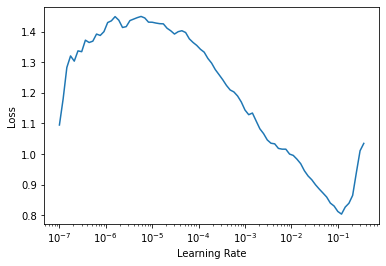

In [19]:
learn.lr_find()

Let me explain, what happens in the next few cells. In Transfer Learning, we need to retain the knowledge learned by the pretrained model. So what happens is, we freeze all the earlier layers and chop off the last classification layer and replace it with a layer with random weights and the correct number outputs, two in this case(it is done by default in fastai when creating the learner through the cnn_learner method).

So, first we train the final layer (with random weights) for 3 epochs, with the one cycle training policy. Then we unfreeze the whole model, find the new suitable learning rate (because we are now updating all the weights) and train for a further 3 epochs.

In [20]:
learn.fit_one_cycle(3, lr_max=1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.168814,0.368405,0.187500,0.812500,03:13
1,0.099094,0.734940,0.312500,0.687500,03:15
2,0.063019,0.439835,0.187500,0.812500,03:17


In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.2908675418875646e-06)

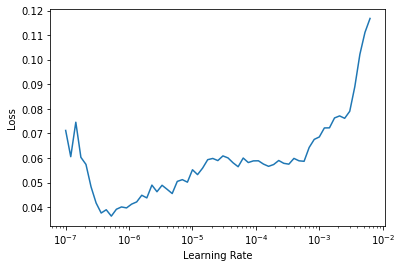

In [22]:
learn.lr_find()

This plot looks different from the other one, since we are now updating all the weights, not just the final random ones, and the first layers don't need too much learning. 4x10<sup>-6</sup> is the suggested learning rate.

Let's train the whole model with the new learning rate:

In [23]:
learn.fit_one_cycle(3, lr_max=4.4e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.053950,0.435164,0.187500,0.812500,03:24
1,0.053677,0.220901,0.062500,0.937500,03:23
2,0.047155,0.361383,0.125000,0.875000,03:23


87.5% accuracy. Not bad for a start, but we will try ways to improve it.

Let us see how our model is doing by inspecting the Confusion Matrix.

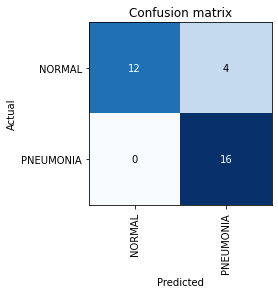

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

Four 'NORMAL' images are being classified as 'PNEUMONIA'. Can this be caused because our model doesn't have enough examples of the 'NORMAL' class to learn about? Let us investigate.

# Solving the Imbalance Problem

The solution to the problem, as with many solutions to problems in Deep Learning, is simple and something that can be implemented easily. Quoting from their conclusions in the paper:
* The method of addressing class imbalance that emerged as
dominant in almost all analyzed scenarios was **oversampling**.
* Oversampling should be applied to the level that completely eliminates the imbalance.
* Oversampling does not cause over
tting of convolutional neural networks.

Basically, Oversampling is artificially making the minority class bigger by replicating it a couple of times. The paper recommends we replicate it until is completely eliminates the imbalance, therefore, our new oversampled 'NORMAL' class is going to be the original images, repeated three times. And we don't have to worry about overfitting of our model too!

In [31]:
os_normal = get_image_files(path/'train'/'NORMAL') * 3
pneumonia = get_image_files(path/'train'/'PNEUMONIA')

print(f"Normal Images: {len(os_normal)}. Pneumonia Images: {len(pneumonia)}")

Normal Images: 4023. Pneumonia Images: 3875


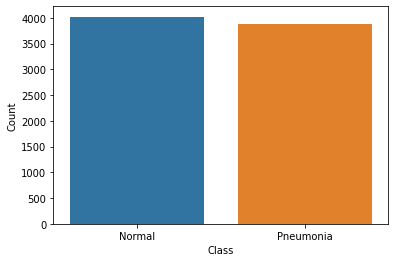

In [32]:
data = [['Normal', len(os_normal)], ['Pneumonia', len(pneumonia)]]
os_df = pd.DataFrame(data, columns=['Class', 'Count'])

sns.barplot(x=os_df['Class'], y=os_df['Count']);

After the Oversampling, the distribution between the classes is almost at per. Now our dataset it balanced and we can train a new model on this Balanced Data.

Now we need a new way to split our dataset when loading it to a DataLoader. Our new Oversampled Path is going to be the Oversampled 'NOMARL' class, the original 'PNEUMONIA' and the validation data. 

Then we create two variables, train_idx and val_idx, that represent the indexes of the respective category of the images, whether train or validation.

In [40]:
os_path = os_normal + pneumonia + val


train_idx = [i for i, fname in enumerate(os_path) if 'train' in str(fname)]
val_idx = [i for i, fname in enumerate(os_path) if 'val' in str(fname)]

In [42]:
L(train_idx), L(val_idx)

((#7898) [0,1,2,3,4,5,6,7,8,9...],
 (#16) [7898,7899,7900,7901,7902,7903,7904,7905,7906,7907...])

Now we have 7898 images in the Train instead of the original 5216, and we still have 16 Validation images. We load them up in a dataloaders object, which our learner expects, find the new optimal learning rate and train the model:

In [51]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=lambda x: [train_idx, val_idx],
    item_tfms=Resize(460),
    batch_tfms=augs
)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0030199517495930195)

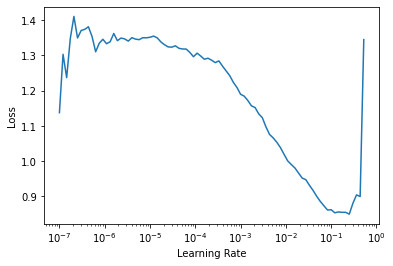

In [52]:
dls = dblock.dataloaders(path)

learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

learn.lr_find()

In [53]:
learn.fit_one_cycle(3, lr_max=2.5e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.346110,0.308598,0.125000,0.875000,02:18
1,0.196921,0.040522,0.000000,1.000000,02:17
2,0.107927,0.038475,0.000000,1.000000,02:19


After just three epochs, we get 100% accuracy on the Validation Set. The Oversampling Solution worked well for us. 

However, as I mentioned before, we only have 16 images on the Validation Set, so its not a good measure on how well our model generalizes.

So I combined the Validation and Test Set into one, and used that as my Validation Set to test how well my model generalizes.

In [66]:
merged_path = os_normal + pneumonia + val + test

train_idx = [i for i, fname in enumerate(merged_path) if 'train' in str(fname)]
val_idx = [i for i, fname in enumerate(merged_path) if 'train' not in str(fname)]

In [68]:
L(train_idx), L(val_idx)

((#7898) [0,1,2,3,4,5,6,7,8,9...],
 (#640) [7898,7899,7900,7901,7902,7903,7904,7905,7906,7907...])

We now have 640 images as our validation. How does our model perform with this new data?

In [1]:
#| include: false
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=lambda x: [train_idx, val_idx],
    item_tfms=Resize(460),
    batch_tfms=augs
)

NameError: name 'DataBlock' is not defined

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.005248074419796467)

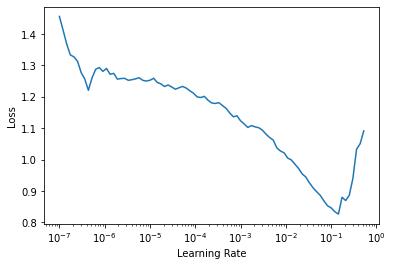

In [70]:
#| include: false
dls = dblock.dataloaders(path)

learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

learn.lr_find()

In [71]:
#| include: false
learn.fit_one_cycle(3, lr_max=1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.277251,0.684108,0.115625,0.884375,02:25
1,0.142877,0.257727,0.073437,0.926562,02:30
2,0.097325,0.064842,0.014062,0.985937,02:27


In [72]:
#| include: false
learn.unfreeze()

SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=1.3182567499825382e-06)

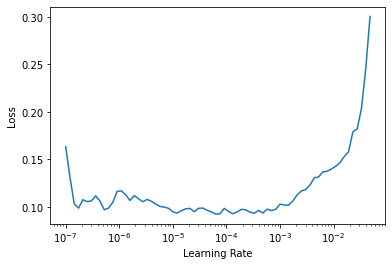

In [73]:
#| include: false
learn.lr_find()

In [74]:
learn.fit_one_cycle(5, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.087615,0.043269,0.014062,0.985937,02:30
1,0.079633,0.041382,0.015625,0.984375,02:30
2,0.067601,0.054884,0.018750,0.981250,02:31
3,0.053627,0.027576,0.006250,0.993750,02:30
4,0.037838,0.025329,0.004688,0.995313,02:27


99.5% accuracy after 5 epochs looks good, looks like our model generalizes well.

See you next time!